In [1]:
%%shell
#Download an FCS file as the example
wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GMBA7WWLblkf4ya8_mjocF1yl_eoxZHE' -O /content/example_fcs.fcs

#Install fcsparser for reading the FCS file
#2025-05-22 Note: Now after installing fcsparser, we need to "Runtime-->Restart session" then run the following cells.
pip install fcsparser

--2025-05-22 19:04:18--  https://docs.google.com/uc?export=download&id=1GMBA7WWLblkf4ya8_mjocF1yl_eoxZHE
Resolving docs.google.com (docs.google.com)... 108.177.12.100, 108.177.12.138, 108.177.12.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.12.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1GMBA7WWLblkf4ya8_mjocF1yl_eoxZHE&export=download [following]
--2025-05-22 19:04:18--  https://drive.usercontent.google.com/download?id=1GMBA7WWLblkf4ya8_mjocF1yl_eoxZHE&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.107.132, 2607:f8b0:400c:c32::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1153673 (1.1M) [application/octet-stream]
Saving to: ‘/content/example_fcs.fcs’

/content/example_fc 100%[===================>]   1.10M  -

In [ ]:
import fcsparser
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

# Import an example flow cytometry file (FCS) and gain ploidy level distribution

In [ ]:
def plot_density_scatter(ax, plot_data, colormap):
  XY=plot_data.values

  if len(XY)>5000:
    ri=np.random.choice(len(XY), 5000)
  else:
    ri=range(len(XY))

  if len(XY)>10:
    xy = np.vstack([XY[ri,0],XY[ri,1]])
    logxy = np.log(xy)
    z = gaussian_kde(logxy,bw_method=0.1)(logxy)

    ax.scatter(XY[ri,0],
                XY[ri,1], c=z,
                s=2, cmap = colormap)
  else:
    ax.scatter(XY[ri,0],
               XY[ri,1], c='k',
               s=2, cmap=colormap)

Total sample volume= 30.007 μL


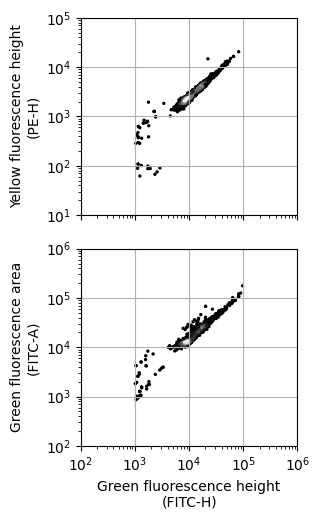

In [ ]:
fig, axs = plt.subplots(figsize = (3.3,5.3), nrows = 2)
file_path = '/content/example_fcs.fcs'
meta, data = fcsparser.parse(file_path,
                              meta_data_only=False,
                              reformat_meta=False)

print('Total sample volume=', float(meta['$VOL'])/1e3, 'μL')


plot_density_scatter(axs[0], data[['FITC-H','PE-H']], colormap = 'Greys_r')
plot_density_scatter(axs[1], data[['FITC-H','FITC-A']], colormap = 'Greys_r')

for ax in axs:
  ax.set_yscale('log')
  ax.set_xscale('log')
  ax.set_xlim(1e2, 1e6)
  ax.grid('on')
axs[0].set_xticklabels([])

axs[0].set_ylim(1e1, 1e5)
axs[1].set_ylim(1e2, 1e6)

axs[0].set_ylabel('Yellow fluorescence height\n(PE-H)')

axs[1].set_xlabel('Green fluorescence height\n(FITC-H)')
axs[1].set_ylabel('Green fluorescence area\n(FITC-A)')

#ax.set_ylim(1e1, 1e5)
#ax.set_xlim(1e2, 1e6)


fig.tight_layout()

fig.savefig('/content/plot_density_example.pdf')
fig.show()

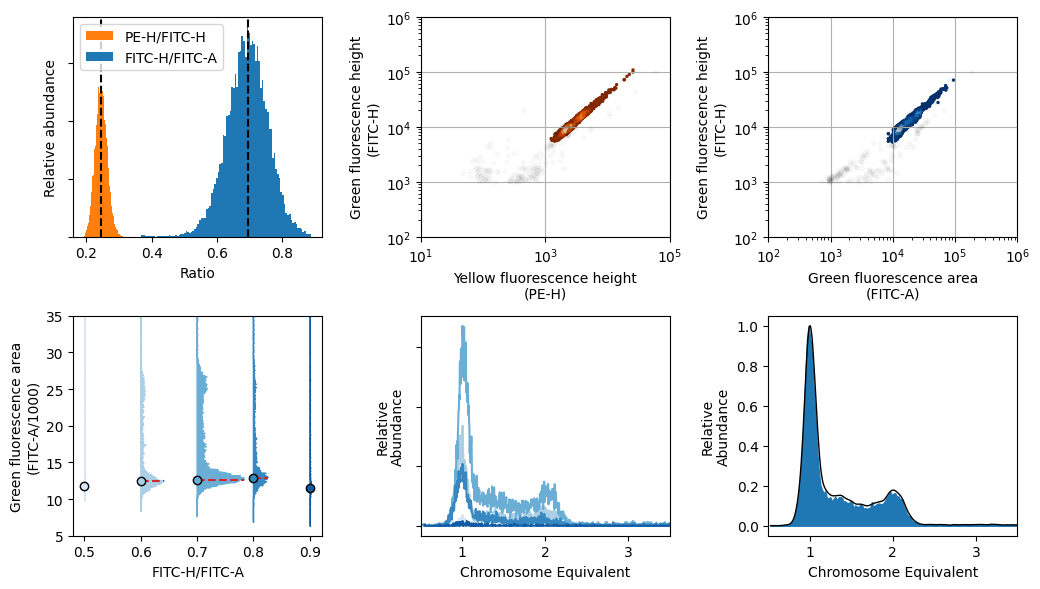

In [ ]:
fit_data=data[['FITC-H','FITC-A', 'PE-H']]

non_cell_data_0 = fit_data[fit_data['FITC-H']<=5000]
fit_data=fit_data[fit_data['FITC-H']>5000]

fig, axss = plt.subplots(figsize=(10.5,6), ncols=3, nrows=2)
axs = axss.flatten()

YG_ratio = fit_data['PE-H']/fit_data['FITC-H']
YG_ratio_l, YG_ratio_u = np.percentile(YG_ratio, [0.1, 99.9])

HA_ratio = fit_data['FITC-H']/fit_data['FITC-A']
HA_ratio_l, HA_ratio_u = np.percentile(HA_ratio, [0.1, 99.9])

non_cell_data_1 = fit_data[(YG_ratio<=YG_ratio_l) | (YG_ratio>=YG_ratio_u) | (HA_ratio<=HA_ratio_l) | (HA_ratio>=HA_ratio_u)]
fit_data = fit_data[(YG_ratio>YG_ratio_l) & (YG_ratio<YG_ratio_u) & (HA_ratio>HA_ratio_l) & (HA_ratio<HA_ratio_u)]

YG_ratio = fit_data['PE-H']/fit_data['FITC-H']
YG_median = np.median(YG_ratio)
YG_std = np.std(YG_ratio)

HA_ratio = fit_data['FITC-H']/fit_data['FITC-A']
HA_median = np.median(HA_ratio)
HA_std = np.std(HA_ratio)

axs[0].hist(YG_ratio, bins=100, color='C1', label = 'PE-H/FITC-H')
axs[0].hist(HA_ratio, bins=100, color='C0', label = 'FITC-H/FITC-A')
axs[0].axvline(YG_median, color='k', linestyle='--')
axs[0].axvline(HA_median, color='k', linestyle='--')
axs[0].set_yticklabels([])
axs[0].set_ylabel('Relative abundance')
axs[0].set_xlabel('Ratio')
axs[0].legend()

cell_data = fit_data[(abs(YG_ratio-YG_median)<3*YG_std) & (abs(HA_ratio-HA_median)<3*HA_std)]
non_cell_data = fit_data[(abs(YG_ratio-YG_median)>=3*YG_std) & (abs(HA_ratio-HA_median)>=HA_std)]
all_non_cell_data = pd.concat([non_cell_data_0, non_cell_data_1])

plot_density_scatter(axs[1], cell_data[['PE-H','FITC-H']], colormap = 'Oranges_r')
plot_density_scatter(axs[2], cell_data[['FITC-A','FITC-H']], colormap = 'Blues_r')

axs[1].plot(all_non_cell_data['PE-H'],all_non_cell_data['FITC-H'], 'k.', alpha=0.02)
axs[2].plot(all_non_cell_data['FITC-A'],all_non_cell_data['FITC-H'], 'k.', alpha=0.02)
#plot_density_scatter(axs[1], all_non_cell_data[['PE-H','FITC-H']], colormap = 'Greys_r')
#plot_density_scatter(axs[2], all_non_cell_data[['FITC-H','FITC-A']], colormap = 'Greys_r')


for ax in axs[[1,2]]:
  ax.set_xscale('log', base = 10)
  ax.set_yscale('log', base = 10)
  ax.set_ylabel('Green fluorescence height\n(FITC-H)')
  ax.set_ylim(1e2, 1e6)
  ax.grid(True)

axs[1].set_xlim(1e1, 1e5)
axs[2].set_xlim(1e2, 1e6)
axs[1].set_xlabel('Yellow fluorescence height\n(PE-H)')
axs[2].set_xlabel('Green fluorescence area\n(FITC-A)')

round_ratio = np.round(HA_ratio, 1)
round_ratio_unique = np.unique(round_ratio)

data_sel = np.array([])
colormap = matplotlib.colormaps['Blues']
color_i = 0

for rru in round_ratio_unique:
  temp_cell_data = cell_data['FITC-A'][abs(HA_ratio-rru)<=0.05]

  if len(temp_cell_data)>=10:
    bin_num = int((temp_cell_data.max()-temp_cell_data.min())/50)
    (count, channel) = np.histogram(temp_cell_data, bins=bin_num)

    base_count=0
    count_bool = (count>base_count)

    output_data_0 = [channel[0:-1][count_bool]+5, count[count_bool]]

    G1_location = output_data_0[0][np.argmax(output_data_0[1])]
    while G1_location > 20000:
      G1_location = G1_location/2

    axs[3].fill_betweenx(channel[1::]/1000, rru+count/2000, rru, color = colormap(color_i))
    axs[3].plot([rru, rru+count.max()/2000], [G1_location/1000, G1_location/1000], 'C3--')
    axs[3].plot(rru, G1_location/1000, 'o', color = colormap(color_i), markeredgecolor='k')

    axs[4].plot(channel[1::]/G1_location, count, '-', color = colormap(color_i))
    data_sel = np.r_[data_sel, temp_cell_data/G1_location]

  color_i += 1/len(round_ratio_unique)
axs[3].set_ylim(5, 35)
axs[3].set_xlabel('FITC-H/FITC-A')
axs[3].set_ylabel('Green fluorescence area\n(FITC-A/1000)')
axs[4].set_yticklabels([])

bin_num = int((data_sel.max()-data_sel.min())*50)
(count, channel) = np.histogram(data_sel, bins=bin_num)

base_count=0
count_bool = (count>base_count)

output_data_0 = [channel[0:-1][count_bool], count[count_bool]]

G1_location = 1.0
gk_function=gaussian_kde(data_sel/G1_location,
                          bw_method=0.05
                          )
X_range=np.arange(data_sel.min()/G1_location,
                    data_sel.max()/G1_location,
                    0.01)
gd=gk_function(X_range)
gd=gd/gd.max()

axs[5].plot(X_range, gd, 'k-', linewidth=1)
axs[5].fill_between(output_data_0[0]/G1_location, output_data_0[1]/count.max(), np.zeros(len(output_data_0[0])), color='C0')
#axs[5].set_yticklabels([])

X_range = np.arange(0,3, 0.01)
X_range = np.round(X_range, 2)
gd=gk_function(X_range)
gd=gd/gd.max()
ridge_line = gd

for ax in axs[[4,5]]:
  ax.set_xticks([1,2,3])
  ax.set_xlim(0.5,3.5)
  ax.set_xlabel('Chromosome Equivalent')
  ax.set_ylabel('Relative\nAbundance')

fig.tight_layout()
fig.savefig('/content/plot_ploidy_level.pdf')
fig.show()

In [ ]:
round_ratio_unique

array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], dtype=float32)

# Analysis on ploidy level distribution

## Cooper-Helmstetter Index

In [ ]:
def interpolate_x_y(x,y):
  x = np.array(x)
  y = np.array(y)

  sort_bool = np.argsort(x)
  x = x[sort_bool]
  y = y[sort_bool]

  x_p = np.arange(np.round(np.min(x),2),np.round(np.max(x),2),0.01)
  y_p = np.interp(x_p,x,y)
  y_p = y_p/np.sum(y_p)

  y_cumsum = np.cumsum(y_p)

  return x_p, y_p, y_cumsum

def get_CH_index(x_p, y_p, y_cumsum, cutoff):
  lower_margin = x_p[np.abs(y_cumsum-cutoff)<0.02].max()
  upper_margin = x_p[np.abs(y_cumsum-(1-cutoff))<0.02].min()
  #ch_index = (np.dot(x_p[y_cumsum>upper_margin], y_p[y_cumsum>upper_margin]/(y_p[y_cumsum>upper_margin].sum()))/
  #            np.dot(x_p[y_cumsum<lower_margin], y_p[y_cumsum<lower_margin]/(y_p[y_cumsum<lower_margin].sum())))
  #print(lower_margin, upper_margin)
  ch_index = upper_margin/lower_margin
  return lower_margin, upper_margin, ch_index

def make_plots(x,y,ax,ax1,ax2,x_label = 'Ploidy level\n(Chromosome equivalents)', raw_data_label = 'Raw data (A.U.)', x_tick = []):
  x = np.array(x)
  y = np.array(y)
  x_p, y_p, y_cumsum = interpolate_x_y(x,y)

  ax.plot(x_p,100*y_p,'k-')

  ax_d = ax.twinx()
  ax_d.plot(x,y,'C3.', mfc = 'none', markersize = 2)
  ax_d.set_ylabel(raw_data_label, color = 'C3')


  ax.set_ylabel('Relative frequency (%)')
  ax.set_xlabel(x_label)

  ax1.plot(x_p,100*y_cumsum,'k-')
  ax1.set_ylabel('Cumulative distribution (%)')
  ax1.set_xlabel(x_label)

  if len(x_tick)==0:
    x_tick = list(range(1, int(np.ceil(np.max(x_p))+1)))

  ax.set_xticks(x_tick)
  ax1.set_xticks(x_tick)

  #colormap = colormaps['Blues_r']
  colormap = matplotlib.colormaps['tab10']
  #cutoffs = 0.01*np.array(list(range(1,11,2)))
  cutoffs = [0.05,0.1,0.15,0.2]
  for i in range(len(cutoffs)):
    cutoff  = cutoffs[i]
    lower_margin, upper_margin, ch_index = get_CH_index(x_p, y_p, y_cumsum, cutoff)
    #ax1.plot([lower_margin, lower_margin], [i*2,100*y_cumsum[x_p==lower_margin][0]], '-', color = colormap(i), linewidth = 1)
    ax1.plot([upper_margin, upper_margin], [100*y_cumsum[x_p==lower_margin][0],100*y_cumsum[x_p==upper_margin][0]], '-', color = colormap(i), linewidth = 1)
    ax1.plot([lower_margin, upper_margin], [100*y_cumsum[x_p==lower_margin][0],100*y_cumsum[x_p==lower_margin][0]], '-', color = colormap(i), linewidth = 1)
    ax2.plot(cutoff*100, ch_index, 'o', color = colormap(i))

  #ax2.set_ylim(1,3)
  ax2.set_xlabel('Cutoff percentage (%)')
  ax2.set_ylabel('Cooper-Helmstetter Index')

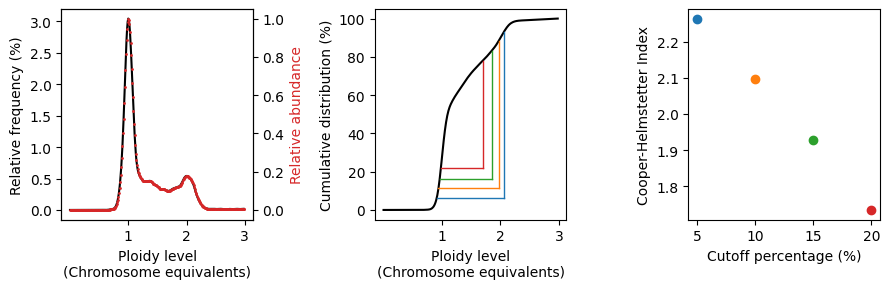

In [ ]:
fig, axs = plt.subplots(figsize=(9,3), ncols=3)

make_plots(X_range, ridge_line,axs[0],axs[1],axs[2],raw_data_label = 'Relative abundance')

fig.tight_layout()
fig.savefig('/content/plot_CH_index.pdf')
fig.show()

## B, C and D periods estimation

### Analytical method

In [ ]:
# @title Estimation of B, C and D periods (analytical)
import random
from scipy.optimize import minimize, curve_fit
from scipy import stats

def get_chromosome_per_cell(X_range, ridge_line):
  return np.dot(ridge_line/np.transpose([ridge_line.sum(axis=1)]), X_range)

def get_cdf(histogram):
  cumsum = np.cumsum(histogram)
  cdf = cumsum/cumsum[-1]

  return cdf

def my_norm_pdf(x_fit, sigma, mu, y_max):
  y_fit = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-0.5*((x_fit - mu)/sigma)**2)
  if np.max(y_fit)!=0:
    output_Y= y_fit/np.max(y_fit)*y_max
  else:
    output_Y = y_fit
  return output_Y

class LR_result:
  def __init__(self, y_fit, ci, pi, slope, intercept, slope_std, intercept_std):
    self.y_fit=y_fit
    self.ci=ci
    self.pi=pi
    self.slope=slope
    self.intercept=intercept
    self.slope_std=slope_std
    self.intercept_var=intercept_std

def linearfit(x, y, x_fit):
  """Linear fit of x and y with uncertainty and plots results."""
  x, y = np.asarray(x), np.asarray(y)
  n = y.size
  p, cov = np.polyfit(x, y, 1, cov=True)  # coefficients and covariance matrix

  perr = np.sqrt(np.diag(cov))     # standard-deviation estimates for each coefficient
  R2 = np.corrcoef(x, y)[0, 1]**2  # coefficient of determination between x and y
  resid = y - np.polyval(p, x)
  s_err = np.sqrt(np.sum(resid**2)/(n - 2))  # standard deviation of the error (residuals)

  # Confidence interval for the linear fit:
  t = stats.t.ppf(0.975, n - 2)
  ci = t * s_err * np.sqrt(    1/n + (x_fit - np.mean(x_fit))**2/np.sum((x_fit-np.mean(x_fit))**2))
  # Prediction interval for the linear fit:
  pi = t * s_err * np.sqrt(1 + 1/n + (x_fit - np.mean(x_fit))**2/np.sum((x_fit-np.mean(x_fit))**2))

  slope = p[0]
  intercept = p[1]
  slope_std = perr[0]
  intercept_std = perr[1]

  y_fit = np.polyval(p, x_fit)

  linear_fit_result = LR_result(y_fit, ci, pi, slope, intercept, slope_std, intercept_std)
  return linear_fit_result

#Ploidy level distributions analysis
def get_log_G(t, G0, tau, C):
  G = G0*(1
          +t*np.log(2)/(tau*(1-2**(-C/tau)))
          -(2**(t/tau)-1)/(2**(C/tau)-1)
          )

  G[t>=C] = G0*(1
              +C*np.log(2)/(tau*(1-2**(-C/tau)))
              -(2**(C/tau)-1)/(2**(C/tau)-1))

  return np.log(G)

#This function only works for bimodal distributions
def get_G1_S_G2(X_range, ridge_line):
  CF_RL_1 = curve_fit(my_norm_pdf, X_range[(X_range<=1.05) & (X_range>=0)], ridge_line[(X_range<=1.05) & (X_range>=0)])
  CF_RL_2 = curve_fit(my_norm_pdf, X_range[X_range>=1.95], ridge_line[X_range>=1.95])


  pdf_1 = my_norm_pdf(X_range, CF_RL_1[0][0], CF_RL_1[0][1],CF_RL_1[0][2])
  pdf_2 = my_norm_pdf(X_range, CF_RL_2[0][0], CF_RL_2[0][1],CF_RL_2[0][2])

  print(CF_RL_1, CF_RL_2)
  shoulder = ridge_line-pdf_1-pdf_2

  return pdf_1, pdf_2, shoulder

def get_genome_distribution(C, time_points, Forks, Genome_points):
  G_linspace=np.array([])
  n_G_A=np.array([])
  for Fi in range(len(Forks)):
    Fork=Forks[Fi]
    if Fork!=0:
      G_linspace_temp = np.arange(Genome_points[Fi]+0.001, Genome_points[Fi+1]-0.001, 0.001)
      #print(np.mean(np.diff(G_linspace_temp)))
      n_G_A_temp = np.log(2)*2**(1-
                                  (G_linspace_temp-Genome_points[Fi]+
                                    time_points[Fi]*Fork/C
                                  )/(Fork/C)
                                )/(Fork/C)

    else:
      G_linspace_temp=Genome_points[Fi]
      n_G_A_temp=(2**(1-time_points[Fi])-2**(1-time_points[Fi+1]))/0.001
    G_linspace=np.r_[G_linspace, G_linspace_temp]
    n_G_A=np.r_[n_G_A, n_G_A_temp]
  #print(np.min(np.diff(G_linspace)))
  return (G_linspace, n_G_A)

def get_replication_forks(C,D):
  C = abs(C)
  D = abs(D)
  #integral number of division cycles
  f_CD=np.floor(C+D).astype(int)
  f_D=np.floor(D).astype(int)
  c_CD=np.ceil(C+D).astype(int)
  c_D=np.ceil(D).astype(int)

  #Four targeted time points:
  #0
  #a_init
  #a_ter
  #1
  a_ter=c_D-D
  a_init=c_CD-(C+D)

  if a_init>a_ter:
    time_points=np.array([0, a_ter, a_init, 1])
    Forks=np.array([(2**f_CD-1)-(2**f_D-1), (2**f_CD-1)-(2**c_D-1), (2**c_CD-1)-(2**c_D-1)])
  else:
    time_points=np.array([0, a_init, a_ter, 1])
    Forks=np.array([(2**f_CD-1)-(2**f_D-1), (2**c_CD-1)-(2**f_D-1), (2**c_CD-1)-(2**c_D-1)])

  coeff_matrix=np.ones((4,3))+np.tril(np.ones((4,3)),-1)
  Genome_points=np.matmul(coeff_matrix,np.diff(time_points)*Forks/C)

  return time_points, Forks, Genome_points

def theoretical_DNA_distribution_CD(C, D):
  time_points, Forks, Genome_points=get_replication_forks(C,D)
  (G_linspace, n_G_A) = get_genome_distribution(C, time_points, Forks, Genome_points)
  return G_linspace, n_G_A

def V_func(xi, u, u0, xj):
  return np.exp(-0.5*((xi-xj)/(u*xj+u0))**2)/(np.sqrt(2*np.pi)*(u*xj+u0))

def experimental_genome_prediction_cv(x_list, C, D, u, u0):
  G_linspace, n_G_A = theoretical_DNA_distribution_CD(C, D)
  xi_list = np.arange(G_linspace[int(np.floor(len(G_linspace)/2))]-G_linspace[0],
                      G_linspace[int(np.floor(len(G_linspace)/2))]+G_linspace[1], 0.01)
  N_xi = np.array([np.sum(n_G_A*V_func(xi, u, u0, G_linspace))*0.01 for xi in xi_list])

  output_Y = np.zeros(len(x_list))

  for i in range(len(xi_list)):
    xi = xi_list[i]
    output_Y[abs(x_list-xi)<=0.01] = N_xi[i]

  if np.max(output_Y)!=0:
    output_Y = output_Y/np.max(output_Y)

  return output_Y

def abs_difference_objective(fitting_parameters, X_range, PDF_data):
  C=abs(fitting_parameters[0])
  D=abs(fitting_parameters[1])
  u=abs(fitting_parameters[2])
  u0=abs(fitting_parameters[3])

  PDF_predict = experimental_genome_prediction_cv(X_range,C,D,u,u0)
  return np.sum(abs(PDF_predict-PDF_data))

def CDF_prediction(X_range,C,D,u,u0):
  output_Y = experimental_genome_prediction_cv(X_range,C,D,u,u0)

  CDF_predict = np.cumsum(output_Y)

  return CDF_predict

def KS_test_objective(fitting_parameters, X_range, CDF_data):
  C=abs(fitting_parameters[0])
  D=abs(fitting_parameters[1])
  u=abs(fitting_parameters[2])
  u0=abs(fitting_parameters[3])

  CDF_predict = CDF_prediction(X_range,C,D,u,u0)
  return np.max(abs(CDF_predict-CDF_data))

def run_optimization(X_range, ridge_line):
  sel_bool = (X_range>=0.8)&(X_range<=2.2)
  ind = random.sample(range(sum(sel_bool)), 100)

  res0 = minimize(abs_difference_objective,
                  (0.40, 0.10, 0.05, 0.01),
                  args = (X_range[sel_bool][ind], ridge_line[sel_bool][ind]),
                      method='L-BFGS-B',
                      bounds=((1e-3, 1), (1e-3, 1), (1e-3, 0.1), (0, 0.02)),
                      options = {'gtol':1e-10,
                                'disp': True,
                                'maxiter': 10000}
                      )

  print(res0.x)

  (C_0, D_0, u_0, u0_0) = res0.x

  res1 = minimize(abs_difference_objective,
                (C_0, D_0, u_0, u0_0),
                args = (X_range[sel_bool][ind], ridge_line[sel_bool][ind]),
                method='Nelder-Mead',
                bounds=((C_0-C_0*0.1, C_0+C_0*0.1), (D_0-D_0*0.1, D_0+D_0*0.1), (1e-3, 0.1), (0, 0.02)),
                options={'disp':True,
                         }
                )

  print(res1.x)

  (C_0, D_0, u_0, u0_0) = res1.x

  CF_result = curve_fit(experimental_genome_prediction_cv, X_range[sel_bool][ind],
                        ridge_line[sel_bool][ind],
                        p0 = [C_0, D_0, u_0, u0_0],
                        method='trf',
                        bounds=((0, 1)),
                        ftol = 1e-10, gtol=1e-10, verbose=2)

  prediction_1 = experimental_genome_prediction_cv(X_range , res1.x[0], res1.x[1], res1.x[2], res1.x[3])
  prediction_2 = experimental_genome_prediction_cv(X_range , CF_result[0][0], CF_result[0][1], CF_result[0][2], CF_result[0][3])

  if sum(abs(prediction_1-ridge_line))>sum(abs(prediction_2-ridge_line)):
    [C,D,u,u0] = CF_result[0]
  else:
    (C,D,u,u0) = res1.x

  return (abs(C),abs(D),abs(u),abs(u0))

[0.4349464  0.15228555 0.05727417 0.0149781 ]
Optimization terminated successfully.
         Current function value: 2.955017
         Iterations: 46
         Function evaluations: 85
[0.44426289 0.14456078 0.05553357 0.01531164]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.2572e-02                                    1.93e-01    
       1              2         6.7267e-02      5.30e-03       1.43e-02       1.43e-02    
       2              3         6.7158e-02      1.10e-04       2.44e-03       7.62e-04    
       3              4         6.7037e-02      1.20e-04       7.11e-03       1.10e-03    
       4              5         6.7016e-02      2.17e-05       2.98e-03       5.38e-04    
       5              6         6.7013e-02      2.62e-06       1.12e-03       2.11e-04    
       6              7         6.7013e-02      1.59e-07       2.15e-04       5.34e-05    
       7              9         6.7013e-02

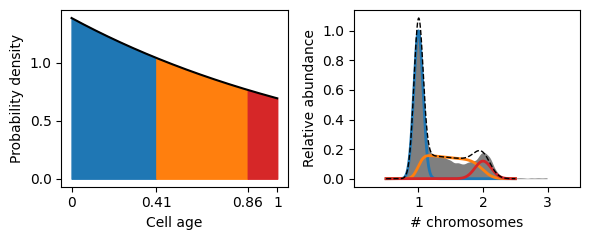

In [ ]:
(C,D,u,u0) = run_optimization(X_range, ridge_line)
B = 1-C-D

print('B=', B, '*tau')
print('C=', C, '*tau')
print('D=', D, '*tau')
print('u=', u)
print('u0=', u0)

G_linspace, n_G_A = theoretical_DNA_distribution_CD(C=C, D=D)

n_B = np.r_[n_G_A[0], np.zeros(len(n_G_A)-1)]
n_C = np.r_[0, n_G_A[1:-1], 0]
n_D = np.r_[np.zeros(len(n_G_A)-1), n_G_A[-1]]

xi_list = np.arange(G_linspace[int(np.floor(len(G_linspace)/2))]-G_linspace[0],
                    G_linspace[int(np.floor(len(G_linspace)/2))]+G_linspace[1], 0.001)
N_xi_B = np.array([np.sum(n_B*V_func(xi, u, u0, G_linspace))*0.001 for xi in xi_list])
N_xi_C = np.array([np.sum(n_C*V_func(xi, u, u0, G_linspace))*0.001 for xi in xi_list])
N_xi_D = np.array([np.sum(n_D*V_func(xi, u, u0, G_linspace))*0.001 for xi in xi_list])

x_axis=xi_list

y_axis0=N_xi_B/np.max(N_xi_B)
y_axis1=N_xi_C/np.max(N_xi_B)
y_axis2=N_xi_D/np.max(N_xi_B)

fig, axs = plt.subplots(ncols=2, figsize=(6,2.5))

ax = axs[0]

a = np.linspace(0, 0.999, 1000)
#n = 2 * np.log(2) * np.exp(-a*np.log(2))
n = np.log(2)*2**(1-a)
ax.plot(a, n, 'k-')

fractions=np.r_[B, C, D]
BCD = np.cumsum(fractions)

ax.fill_between(a[a<=BCD[0]],
                 n[a<=BCD[0]],
                 0, color='C0')

ax.fill_between(a[(a>BCD[0]) & (a<=BCD[1])],
                 n[(a>BCD[0]) & (a<=BCD[1])],
                 0, color='C1')

ax.fill_between(a[a>BCD[1]],
                 n[a>BCD[1]],
                 0, color='C3')

ax.set_xlabel('Cell age')
ax.set_ylabel('Probability density')

ax.set_xticks([0, BCD[0], BCD[1], 1])
ax.set_xticklabels([0, np.round(BCD[0],2),
                     np.round(BCD[1],2), 1])

ax = axs[1]
ax.fill_between(X_range, ridge_line, np.zeros(len(ridge_line))+y_base,
                  color='k',
                  linewidth=0, alpha=0.5)

ax.plot(x_axis, y_axis0, lw=2, c='C0')
ax.plot(x_axis, y_axis1, lw=2, c='C1')
ax.plot(x_axis, y_axis2, lw=2, c='C3')

ax.plot(x_axis, y_axis0+y_axis1+y_axis2, 'k--', lw = 1)

ax.set_xlim(0,3.5)
ax.set_xlabel('# chromosomes')
ax.set_xticks([1,2,3])
ax.set_xticklabels([1,2,3])
ax.set_ylabel('Relative abundance')

fig.tight_layout()
fig.savefig('/content/BCD_periods_estimations.pdf')
fig.show()

### Numerical method: for verification

In [ ]:
class Cell:
  def __init__(self, chromosome, age, tau, cyc_age, tau_cyc, chr_rep_on, B, C):
    self.chromosome = chromosome
    self.age = age
    self.tau = tau
    self.cyc_age = cyc_age
    self.tau_cyc = tau_cyc
    self.chr_rep_on = chr_rep_on
    self.B = B
    self.C = C

  def display_parameters(self):
    return {'chromosome': self.chromosome,
            'age': self.age,
            'tau': self.tau,
            'cyc_age': self.cyc_age,
            'tau_cyc': self.tau_cyc,
            'chr_rep_on': self.chr_rep_on,
            'B': self.B,
            'C': self.C
            }

  def reset_cell(self):
    new_cell_tau = 0.0
    while new_cell_tau<=0:
      new_cell_tau = np.random.normal(tau, tau*0.1)
    self.tau_cyc = new_cell_tau/self.tau*self.tau_cyc
    self.tau = new_cell_tau

  def cell_division(self):
    self.chromosome = self.chromosome/2
    self.age = 0
    self.reset_cell()

    new_cell = Cell(chromosome=self.chromosome,
                    age=0.0,
                    tau=self.tau,
                    cyc_age=self.tau_cyc-self.B,
                    tau_cyc=self.tau_cyc,
                    chr_rep_on=False,
                    B = self.B,
                    C = self.C)

    return new_cell

  def cell_cycle_progress(self):
    #progress of the chromosome cycle
    if self.cyc_age >= self.tau_cyc:
      self.cyc_age=0
      self.chr_rep_on=True
    else:
      self.cyc_age = self.cyc_age + 1

    if self.chr_rep_on:
      self.chromosome = self.chromosome + 1/self.C

    if abs(self.chromosome-np.ceil(self.chromosome))<(1/self.C):
      self.chromosome = np.ceil(self.chromosome)
      self.chr_rep_on = False

    #progress of the cell division cycle
    #potential outputs:
    #1. cell not divided but becomes older (cell age +1)
    #2. cell being divided into two cells (cells' ages being reset to 0)
    if (self.age >= self.tau) and (abs(self.chromosome-2)<(1/self.C)):
      new_cell = self.cell_division()
      cell_array = np.array([self, new_cell])
    else:
      self.age = self.age+1
      cell_array = np.array([self])

    return cell_array

In [ ]:
tau = 100.0
tau_cyc = 100.0

B_period = B*tau
C_period = C*tau

first_cell = Cell(chromosome=1.0,
                  age=0,
                  tau=tau,
                  cyc_age=tau_cyc-B_period,
                  tau_cyc=tau_cyc,
                  chr_rep_on=False,
                  B = B_period,
                  C = C_period)

all_cell_array = np.array([first_cell])
N_list = []
N = 1

t_0 = 0
t_max = 4000

t_array = np.linspace(t_0, t_max, 4001)

In [ ]:
for i in range(len(t_array)):
  t = t_array[i]
  start_sample_size = len(all_cell_array)

  for j in range(start_sample_size):
    target_cell = all_cell_array[j]
    return_cell_list = target_cell.cell_cycle_progress()

    target_cell = return_cell_list[0]

    if len(return_cell_list)>1:
      all_cell_array = np.r_[all_cell_array, return_cell_list[1::]]

  end_sample_size = len(all_cell_array)
  N = int(N*float(end_sample_size)/float(start_sample_size))
  N_list.append(N)

  if end_sample_size>10000:
    sample_i = np.random.choice(range(end_sample_size), size=10000, replace=False)
    all_cell_array = all_cell_array[sample_i]

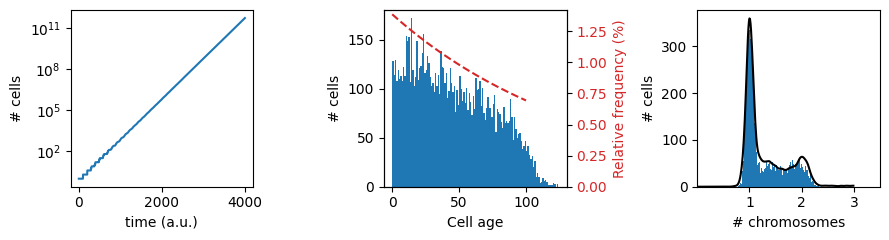

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(9,2.5))

ax = axs[0]
ax.plot(N_list)
ax.set_yscale('log')
ax.set_xlabel('time (a.u.)')
ax.set_ylabel('# cells')

ax1 = axs[1]
cell_age_list = np.array([a.age for a in all_cell_array])
ax1.hist(cell_age_list,
         bins=int((np.max(cell_age_list)-np.min(cell_age_list))))

ax1d = ax1.twinx()
a = np.linspace(0, 0.999, 1000)
n = np.log(2)*2**(1-a)
ax1d.plot(a*100, n, 'C3--')

ax1.set_ylim(bottom=0)
ax1d.set_ylim(bottom=0)
ax1.set_xlabel('Cell age')
ax1.set_ylabel('# cells')
ax1d.set_ylabel('Relative frequency (%)', color='C3')
ax1d.tick_params(axis='y', labelcolor='C3')

ax2 = axs[2]
chrm_list = np.array([a.chromosome for a in all_cell_array])
u = 0.06
u0 = 0.01
fl_list = np.array([chrm_list[i]+np.random.normal(0, u*chrm_list[i])+np.random.normal(0, u0)
                    for i in range(len(chrm_list))])
counts, bins = np.histogram(fl_list, bins=int((np.max(fl_list)-np.min(fl_list))*100))
ax2.stairs(counts, bins, fill=True)

ax2.plot(X_range, np.max(counts)*ridge_line, 'k-')
ax2.set_xlim(0,3.5)
ax2.set_xlabel('# chromosomes')
ax2.set_ylabel('# cells')

ax2.set_xticks([1,2,3])
ax2.set_xticklabels([1,2,3])

fig.tight_layout()

fig.savefig('/content/simulation_output.pdf')
fig.show()